In [1]:
import numpy as np
import random
import tensorflow as tf
import pandas as pd
import cv2


In [2]:
seed_constant = 42
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [3]:
import os


base_path = r"D:\Desktop\Internship\Research Paper\Robot dataset\save"
positive_path = os.path.join(base_path, "Positive")
negative_path = os.path.join(base_path, "Negative")

In [4]:
def load_images_from_folder(folder_path, target_size=(64, 64), max_frames=20):
    images = []
    for filename in sorted(os.listdir(folder_path))[:max_frames]:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(folder_path, filename)
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype('float32') / 255.0
                images.append(img)
    # Pad with zeros if fewer than max_frames
    while len(images) < max_frames:
        images.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.float32))
    return np.array(images[:max_frames])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def augment_sequences(X, y, class_to_augment=0, num_augmented=60):
    if len(X) == 0 or len(y) == 0:
        print("Warning: No sequences available for augmentation.")
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)
    
    neg_indices = np.where(y == class_to_augment)[0]
    if len(neg_indices) == 0:
        print(f"Warning: No sequences found for class {class_to_augment} (Negative). Skipping augmentation.")
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )
    X_aug, y_aug = [], []
    
    for idx in np.random.choice(neg_indices, num_augmented, replace=True):
        sequence = X[idx]
        aug_sequence = []
        for frame in sequence:
            frame = frame.reshape(1, 64, 64, 3)
            aug_frame = next(datagen.flow(frame, batch_size=1))[0]
            aug_sequence.append(aug_frame)
        X_aug.append(np.array(aug_sequence))
        y_aug.append(class_to_augment)
    
    # To Ensure output is a properly shaped NumPy array
    X_result = np.concatenate([X, X_aug], axis=0).astype(np.float32)
    y_result = np.concatenate([y, y_aug], axis=0).astype(np.int32)
    return X_result, y_result

In [6]:
X_sequences = []
y_sequences = []
folder_names = []

print("Loading sequences...")
valid_sequences = 0
invalid_sequences = 0

for class_dir, label in [("Positive", 1), ("Negative", 0)]:
    class_path = os.path.join(base_path, class_dir)
    
    if not os.path.exists(class_path):
        print(f"Error: Directory not found: {class_path}")
        continue
    
    folder_list = sorted(os.listdir(class_path))
    print(f"Found {len(folder_list)} folders in {class_dir} directory")
    
    if len(folder_list) == 0:
        print(f"Warning: {class_dir} directory is empty")
    
    for folder_name in folder_list:
        folder_path = os.path.join(class_path, folder_name)
        
        if os.path.isdir(folder_path):
            images = load_images_from_folder(folder_path)
            print(f"Folder {folder_name} in {class_dir} has {len(images)} frames after processing")
            
            if len(images) == 20:
                X_sequences.append(images)
                y_sequences.append(label)
                folder_names.append(folder_name)
                valid_sequences += 1
                if valid_sequences % 20 == 0:
                    print(f"Loaded {valid_sequences} sequences...")
            else:
                print(f"Folder {folder_name} in {class_dir} processed to 20 frames (originally {len(images)}).")
                invalid_sequences += 1
        else:
            print(f"Warning: {folder_path} is not a directory")

# Convert to NumPy arrays before augmentation
X_sequences = np.array(X_sequences, dtype=np.float32)
y_sequences = np.array(y_sequences, dtype=np.int32)

# Check label distribution before augmentation
print(f"Pre-augmentation data shape: {X_sequences.shape}")
print(f"Pre-augmentation label distribution: {np.bincount(y_sequences)}")
if 0 not in np.unique(y_sequences):
    print("Error: No Negative sequences loaded. Please check the Negative directory for valid folders with images.")
    print("Proceeding with available data (single-class training may result in trivial accuracy).")
else:
    X_sequences, y_sequences = augment_sequences(X_sequences, y_sequences, class_to_augment=0, num_augmented=60)
    print(f"Augmented data shape: {X_sequences.shape}")
    print(f"Augmented label distribution: {np.bincount(y_sequences)}")

print(f"Loaded {valid_sequences} valid sequences")
print(f"Processed {invalid_sequences} invalid sequences (padded/truncated)")
print(f"Final data shape: {X_sequences.shape}")
print(f"Label distribution: {np.bincount(y_sequences)}")

Loading sequences...
Found 116 folders in Positive directory
Folder manual#split_train#episode_0#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_100#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_101#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_102#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_103#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_104#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_105#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_106#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_107#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_108#_0 in Positive has 20 frames after processing
Folder manual#split_train#episode_109#_0 in Positive has 20 frames after processing
Folder manual#spl

In [7]:
from sklearn.model_selection import train_test_split

if len(np.unique(y_sequences)) < 2:
    print("Warning: Only one class present. Train-test split may be unbalanced.")
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_sequences, 
        y_sequences, 
        test_size=0.3,
        random_state=seed_constant
    )
else:
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_sequences, 
        y_sequences, 
        test_size=0.3,
        random_state=seed_constant, 
        stratify=y_sequences
    )

print("Sequence Data Ready")
print("Train shape:", X_train_seq.shape)
print("Test shape:", X_test_seq.shape)
print("Train label distribution:", np.bincount(y_train_seq))
print("Test label distribution:", np.bincount(y_test_seq))

Sequence Data Ready
Train shape: (163, 20, 64, 64, 3)
Test shape: (70, 20, 64, 64, 3)
Train label distribution: [82 81]
Test label distribution: [35 35]


In [8]:
# Maintain original indices before augmentation
original_indices = np.arange(len(folder_names))  # Only real, original 173 folders

# Perform stratified split on only original data
train_indices, test_indices = train_test_split(
    original_indices,
    test_size=0.3,
    random_state=seed_constant,
    stratify=y_sequences[:len(folder_names)]  # Use only original labels for stratification
)

folder_names = np.array(folder_names)
folder_names_train = folder_names[train_indices]
folder_names_test = folder_names[test_indices]

print("\nSample of Folders in Test Set:")
for i, folder in enumerate(folder_names_test[:20]):
    print(f"{i+1:2d}. {folder}")


Sample of Folders in Test Set:
 1. manual#split_train#episode_111#_0
 2. manual#split_train#episode_96#_0
 3. manual#split_train#episode_106#_0
 4. manual#split_train#episode_112#_0
 5. manual#split_train#episode_76#_0
 6. manual#split_train#episode_19#_0
 7. manual#split_train#episode_146#_0
 8. manual#split_train#episode_158#_0
 9. manual#split_train#episode_162#_0
10. manual#split_train#episode_102#_0
11. manual#split_train#episode_6#_0
12. manual#split_train#episode_150#_0
13. manual#split_train#episode_166#_0
14. manual#split_train#episode_100#_0
15. manual#split_train#episode_41#_0
16. manual#split_train#episode_148#_0
17. manual#split_train#episode_164#_0
18. manual#split_train#episode_59#_0
19. manual#split_train#episode_145#_0
20. manual#split_train#episode_72#_0


In [9]:
def create_label_report(X_sequences, y_sequences, folder_names):
    print("="*60)
    print("COMPLETE LABEL VERIFICATION REPORT")
    print("="*60)
    
    unique_labels, counts = np.unique(y_sequences, return_counts=True)
    print(f"Total sequences: {len(y_sequences)}")
    for label, count in zip(unique_labels, counts):
        label_name = "Positive" if label == 1 else "Negative"
        print(f"Label {label} ({label_name}): {count} sequences")
    
    print("\n" + "="*40)
    print("SAMPLE FOLDER → LABEL MAPPINGS:")
    print("="*40)
    
    indices_to_show = list(range(10)) + list(range(len(folder_names)-10, len(folder_names)))
    
    for i in indices_to_show:
        if i < len(folder_names):
            label_name = "Positive" if y_sequences[i] == 1 else "Negative"
            print(f"{i:3d}. {folder_names[i]:<30} → {y_sequences[i]} ({label_name})")
        if i == 9:
            print("    ...")
    
    return True

create_label_report(X_sequences, y_sequences, folder_names)

COMPLETE LABEL VERIFICATION REPORT
Total sequences: 233
Label 0 (Negative): 117 sequences
Label 1 (Positive): 116 sequences

SAMPLE FOLDER → LABEL MAPPINGS:
  0. manual#split_train#episode_0#_0 → 1 (Positive)
  1. manual#split_train#episode_100#_0 → 1 (Positive)
  2. manual#split_train#episode_101#_0 → 1 (Positive)
  3. manual#split_train#episode_102#_0 → 1 (Positive)
  4. manual#split_train#episode_103#_0 → 1 (Positive)
  5. manual#split_train#episode_104#_0 → 1 (Positive)
  6. manual#split_train#episode_105#_0 → 1 (Positive)
  7. manual#split_train#episode_106#_0 → 1 (Positive)
  8. manual#split_train#episode_107#_0 → 1 (Positive)
  9. manual#split_train#episode_108#_0 → 1 (Positive)
    ...
163. manual#split_train#episode_74#_0 → 0 (Negative)
164. manual#split_train#episode_77#_0 → 0 (Negative)
165. manual#split_train#episode_81#_0 → 0 (Negative)
166. manual#split_train#episode_85#_0 → 0 (Negative)
167. manual#split_train#episode_9#_0 → 0 (Negative)
168. manual#split_train#episode_9

True

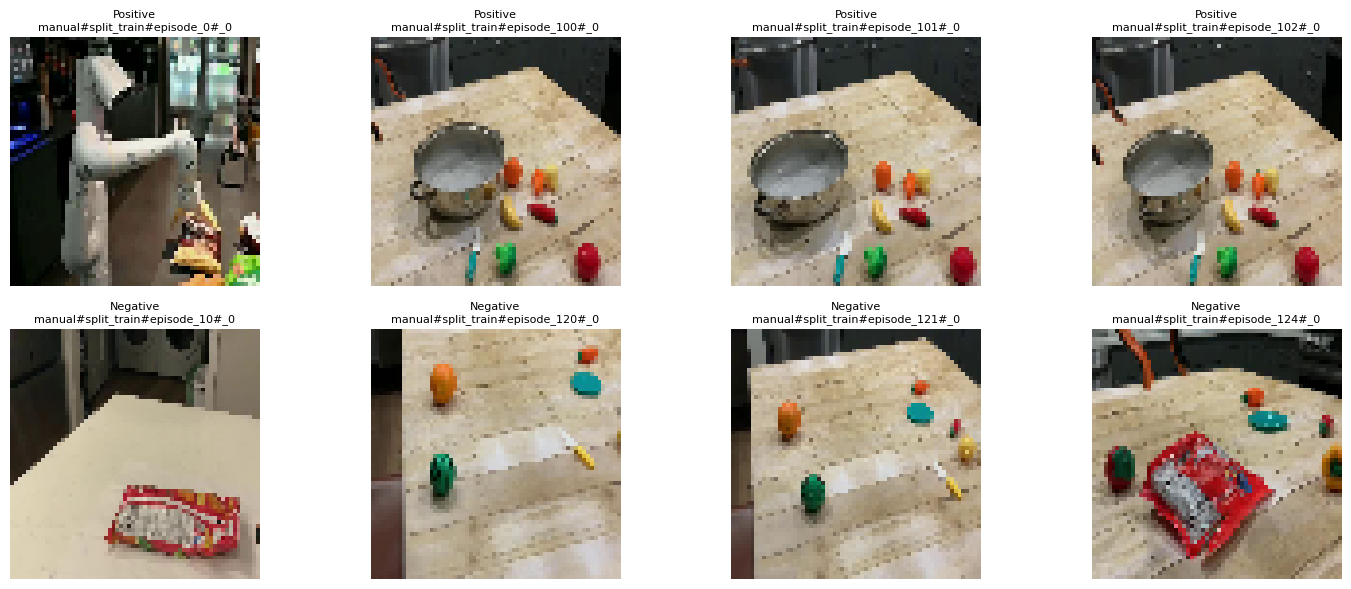

In [10]:
import matplotlib.pyplot as plt

def visual_label_check(X_sequences, y_sequences, folder_names, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    pos_indices = np.where(y_sequences == 1)[0][:num_samples]
    neg_indices = np.where(y_sequences == 0)[0][:num_samples]
    
    for i in range(num_samples):
        if i < len(pos_indices):
            idx = pos_indices[i]
            axes[0, i].imshow(X_sequences[idx][0])
            axes[0, i].set_title(f"Positive\n{folder_names[idx]}", fontsize=8)
        else:
            axes[0, i].set_title("No Positive sample", fontsize=8)
        axes[0, i].axis('off')
    
    for i in range(num_samples):
        if i < len(neg_indices):
            idx = neg_indices[i]
            axes[1, i].imshow(X_sequences[idx][0])
            axes[1, i].set_title(f"Negative\n{folder_names[idx]}", fontsize=8)
        else:
            axes[1, i].set_title("No Negative sample", fontsize=8)
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

visual_label_check(X_sequences, y_sequences, folder_names)

In [11]:
def check_sequence_similarity(X, y, num_samples=5):
    print("Checking sequence similarity...")
    pos_indices = np.where(y == 1)[0][:num_samples]
    neg_indices = np.where(y == 0)[0][:num_samples]
    
    if len(pos_indices) == 0:
        print("No Positive sequences available.")
    else:
        for idx in pos_indices:
            seq = X[idx]
            mean_pixel = np.mean(seq, axis=(0, 1, 2, 3))
            std_pixel = np.std(seq, axis=(0, 1, 2, 3))
            print(f"Positive sequence {folder_names[idx]}: Mean pixel={mean_pixel:.3f}, Std pixel={std_pixel:.3f}")
    
    if len(neg_indices) == 0:
        print("No Negative sequences available.")
    else:
        for idx in neg_indices:
            seq = X[idx]
            mean_pixel = np.mean(seq, axis=(0, 1, 2, 3))
            std_pixel = np.std(seq, axis=(0, 1, 2, 3))
            print(f"Negative sequence {folder_names[idx]}: Mean pixel={mean_pixel:.3f}, Std pixel={std_pixel:.3f}")

check_sequence_similarity(X_sequences, y_sequences)

Checking sequence similarity...
Positive sequence manual#split_train#episode_0#_0: Mean pixel=0.310, Std pixel=0.260
Positive sequence manual#split_train#episode_100#_0: Mean pixel=0.490, Std pixel=0.252
Positive sequence manual#split_train#episode_101#_0: Mean pixel=0.501, Std pixel=0.247
Positive sequence manual#split_train#episode_102#_0: Mean pixel=0.489, Std pixel=0.250
Positive sequence manual#split_train#episode_103#_0: Mean pixel=0.463, Std pixel=0.257
Negative sequence manual#split_train#episode_10#_0: Mean pixel=0.505, Std pixel=0.280
Negative sequence manual#split_train#episode_120#_0: Mean pixel=0.517, Std pixel=0.242
Negative sequence manual#split_train#episode_121#_0: Mean pixel=0.503, Std pixel=0.244
Negative sequence manual#split_train#episode_124#_0: Mean pixel=0.455, Std pixel=0.252
Negative sequence manual#split_train#episode_125#_0: Mean pixel=0.499, Std pixel=0.254


In [12]:
from sklearn.utils.class_weight import compute_class_weight

if len(np.unique(y_train_seq)) < 2:
    print("Warning: Only one class in training data. Class weights set to default.")
    class_weight_dict = {0: 1.0, 1: 1.0}
else:
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_seq),
        y=y_train_seq
    )
    class_weights_array[0] *= 1.5
    class_weight_dict = dict(zip(np.unique(y_train_seq), class_weights_array))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.4908536585365852, 1: 1.0061728395061729}


In [13]:
from tensorflow.keras.layers import TimeDistributed, BatchNormalization, Dense, Dropout, Flatten, ConvLSTM2D, MaxPooling3D, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2

CLASSES_LIST = ['Positive', 'Negative']

def create_convlstm_model():
    cnn = tf.keras.models.Sequential()

    cnn.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh', return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2, input_shape=(20, 64, 64, 3)))
    cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same"))
    cnn.add(TimeDistributed(BatchNormalization()))

    cnn.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))
    cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same"))
    cnn.add(TimeDistributed(BatchNormalization()))

    cnn.add(ConvLSTM2D(filters=128, kernel_size=(3, 3), activation='tanh', return_sequences=True,
                       recurrent_dropout=0.2, dropout=0.2))
    cnn.add(MaxPooling3D(pool_size=(1, 2, 2), padding="same"))
    cnn.add(TimeDistributed(BatchNormalization()))

    cnn.add(TimeDistributed(Flatten()))
    cnn.add(GlobalAveragePooling1D())  # Replaced Attention with GlobalAveragePooling1D
    cnn.add(Flatten())

    cnn.add(Dropout(0.3))
    cnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    cnn.add(Dropout(0.3))
    cnn.add(Dense(1, activation='sigmoid'))

    cnn.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    cnn.summary()
    return cnn

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
import gc

def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

lr_schedule_callback = LearningRateScheduler(lr_scheduler)

gc.collect()
tf.keras.backend.clear_session()

convlstm_model = create_convlstm_model()
print("ConvLSTM Model Created")

convlstm_model_training = convlstm_model.fit(
    x=X_train_seq,
    y=y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=8,
    shuffle=True,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback, reduce_lr_callback, lr_schedule_callback],
    verbose=1
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 32)    40448     
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 32)    0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 32)    128       
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 64)    221440    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 64)    0         
 g3D)                                                            
                                                      

In [15]:
# Run this in a new cell to check what happened
print("Checking model and training status...")

# Check if model still exists
try:
    print(f"Model exists: {convlstm_model is not None}")
    print(f"Training history exists: {convlstm_model_training is not None}")
    print(f"Epochs completed: {len(convlstm_model_training.history['loss'])}")
    print(f"Final validation loss: {convlstm_model_training.history['val_loss'][-1]}")
except:
    print("Model or training history not accessible")

Checking model and training status...
Model exists: True
Training history exists: True
Epochs completed: 25
Final validation loss: 1.5996851921081543


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score

print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE")
print("="*50)

y_pred_proba = convlstm_model.predict(X_test_seq, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

auc = roc_auc_score(y_test_seq, y_pred_proba)
accuracy = (y_pred == y_test_seq).mean()
f1 = f1_score(y_test_seq, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_seq, y_pred).ravel()
neg_acc = tn / (tn + fp) if (tn + fp) > 0 else 0
pos_acc = tp / (tp + fn) if (tp + fn) > 0 else 0
balanced_acc = (neg_acc + pos_acc) / 2

print(f"Overall Accuracy: {accuracy:.1%}")
print(f"AUC Score: {auc:.3f}")
print(f"Precision: {tp/(tp+fp):.1%}")
print(f"Recall: {tp/(tp+fn):.1%}")
print(f"F1-Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.1%}")
print(f"Negative Class Acc: {neg_acc:.1%}")
print(f"Positive Class Acc: {pos_acc:.1%}")
print(f"\nConfusion Matrix: [TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}]")
print("="*50)


🎯 FINAL MODEL PERFORMANCE
📊 Overall Accuracy: 81.4%
📈 AUC Score: 0.853
🎯 Precision: 72.9%
🔍 Recall: 100.0%
⚖️ F1-Score: 0.843
✅ Balanced Accuracy: 81.4%
⚖️ Negative Class Acc: 62.9%
✅ Positive Class Acc: 100.0%

📋 Confusion Matrix: [TN:22, FP:13, FN:0, TP:35]


In [17]:
def predict_video_class(model, video_path, target_size=(64, 64), num_frames=20):
    import cv2
    import numpy as np

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        print("Video has fewer frames than required.")
        return None

    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
    selected_frames = []
    frame_pos = 0
    current_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_pos == frame_indices[current_index]:
            frame = cv2.resize(frame, target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype('float32') / 255.0
            selected_frames.append(frame)
            current_index += 1
            if current_index >= len(frame_indices):
                break
        frame_pos += 1

    cap.release()

    if len(selected_frames) < num_frames:
        print(" Not enough frames extracted")
        return None

    video_array = np.expand_dims(np.array(selected_frames), axis=0)  # Shape: (1, 20, 64, 64, 3)
    prediction = model.predict(video_array)[0][0]
    predicted_class = "Positive" if prediction > 0.5 else "Negative"

    print(f"\n Predicted Class: {predicted_class} ({prediction:.3f} confidence)")
    return predicted_class

In [ ]:
video_path = r"D:\Desktop\Internship\Research Paper\Robot dataset\train\manual#split_train#episode_19#_0.mp4"
predict_video_class(convlstm_model, video_path)

1/1 [==============================] - 0s 269ms/step

 Predicted Class: Negative (0.112 confidence)


'Negative'